In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

In [21]:
# Load data
metadata_path = '../data/id_metadata.csv'
listening_history_path = '../data/listening_history.csv'
metadata_df = pd.read_csv(metadata_path, delimiter='\t')
listening_history_df = pd.read_csv(listening_history_path, delimiter='\t')

In [22]:
listening_history_df 

,user,song,timestamp
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28
1,user_007XIjOr,dGeyvi5WCOjDU7da,2019-02-20 12:35
2,user_007XIjOr,qUm54NYOjeFhmKYx,2019-02-20 12:48
3,user_007XIjOr,FtnuMT1DlevSR2n5,2019-02-20 12:52
4,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:09
...,...,...,...
5109587,user_zzWscYTy,BBiswLufo26YQCT7,2019-01-10 15:57
5109588,user_zzWscYTy,5ZHgff3sjETIiedr,2019-01-10 16:21
5109589,user_zzWscYTy,m4O1iLh6fC43xjRy,2019-01-10 16:48
5109590,user_zzWscYTy,mvUaP8k67qOFfA65,2019-01-10 21:13


In [4]:

# Preprocessing
listening_history_df['timestamp'] = pd.to_datetime(listening_history_df['timestamp'])
listening_history_df.sort_values(by=['user', 'timestamp'], inplace=True)
user_encoder = LabelEncoder()
song_encoder = LabelEncoder()
listening_history_df['user_id'] = user_encoder.fit_transform(listening_history_df['user'])
listening_history_df['song_id'] = song_encoder.fit_transform(listening_history_df['song'])

In [5]:
# Classify time of day
def classify_time_of_day(timestamp):
    hour = timestamp.hour
    if 4 <= hour < 12:
        return 1
    elif 12 <= hour < 20:
        return 2
    else:
        return 3

In [6]:
listening_history_df['time_of_day'] = listening_history_df['timestamp'].apply(classify_time_of_day)

In [7]:
# Scale metadata features
features_to_scale = ['popularity', 'release', 'danceability', 'energy', 'key', 'mode', 'valence', 'tempo', 'duration_ms']
scaler = MinMaxScaler()
metadata_df.set_index('id', inplace=True)
metadata_df[features_to_scale] = scaler.fit_transform(metadata_df[features_to_scale])


In [8]:
# Get song metadata
def get_song_metadata(song_id):
    if song_id in metadata_df.index:
        metadata = metadata_df.loc[song_id, features_to_scale]
        return metadata.values
    else:
        return np.zeros(len(features_to_scale))

In [9]:
# Generate sequences and labels
sequence_length = 10
song_sequences = []
next_song_labels = []
metadata_sequences = []

for user in listening_history_df['user_id'].unique():
    user_df = listening_history_df[listening_history_df['user_id'] == user]
    user_songs = user_df['song_id'].tolist()

    for i in range(len(user_songs) - sequence_length):
        song_sequence = user_songs[i:i + sequence_length]
        next_song = user_songs[i + sequence_length]
        metadata_sequence = [get_song_metadata(song) for song in song_sequence]

        song_sequences.append(song_sequence)
        next_song_labels.append(next_song)
        metadata_sequences.append(metadata_sequence)

In [10]:
# Prepare input arrays
user_array = np.array([np.full(shape=(sequence_length,), fill_value=user_id) for user_id, _ in enumerate(song_sequences)])
song_array = np.array(song_sequences)
metadata_array = np.array(metadata_sequences)
label_array = np.array(next_song_labels)

# Updated number of unique users and songs
num_users = listening_history_df['user_id'].nunique()
num_songs = listening_history_df['song_id'].nunique()



In [11]:
# Split data
test_size = 0.2
train_user_array, val_user_array, train_song_array, val_song_array, train_metadata_array, val_metadata_array, train_label_array, val_label_array = train_test_split(
    user_array, song_array, metadata_array, label_array, test_size=test_size, random_state=42)

In [12]:
print("Max user ID in training set:", np.max(train_user_array))
print("Max song ID in training set:", np.max(train_song_array))

Max user ID in training set: 9729
Max song ID in training set: 4357


In [16]:
# Model definition
num_users = len(user_encoder.classes_)
num_songs = len(song_encoder.classes_)
metadata_dim = len(features_to_scale)

user_input = Input(shape=(sequence_length,), name='user_input')
# user_embedding = Embedding(num_users, 50, input_length=sequence_length)(user_input)

song_input = Input(shape=(sequence_length,), name='song_input')
# song_embedding = Embedding(num_songs, 50, input_length=sequence_length)(song_input)

user_embedding = Embedding(input_dim=np.max(train_user_array)+1, output_dim=50, input_length=sequence_length)(user_input)
song_embedding = Embedding(input_dim=np.max(train_song_array)+1, output_dim=50, input_length=sequence_length)(song_input)

metadata_input = Input(shape=(sequence_length, metadata_dim), name='metadata_input')

concatenated = concatenate([user_embedding, song_embedding, metadata_input])
lstm_layer = LSTM(128, return_sequences=False)(concatenated)
dense_layer = Dense(64, activation='relu')(lstm_layer)
dense_layer1 = Dense(64, activation='relu')(dense_layer)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
dense_layer3 = Dense(64, activation='relu')(dense_layer2)
dropout_layer = Dropout(0.2)(dense_layer3)
output_layer = Dense(num_songs, activation='softmax')(dropout_layer)

model = Model(inputs=[user_input, song_input, metadata_input], outputs=output_layer)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 10)]         0           []                               
                                                                                                  
 song_input (InputLayer)        [(None, 10)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 10, 50)       486500      ['user_input[0][0]']             
                                                                                                  
 embedding_3 (Embedding)        (None, 10, 50)       217900      ['song_input[0][0]']             
                                                                                            

Epoch 1/20
244/244 [==============================] - 5s 14ms/step - loss: 7.9113 - accuracy: 0.0089 - val_loss: 7.7227 - val_accuracy: 0.0123
Epoch 2/20
244/244 [==============================] - 3s 12ms/step - loss: 7.3818 - accuracy: 0.0092 - val_loss: 7.8368 - val_accuracy: 0.0134
Epoch 3/20
244/244 [==============================] - 3s 12ms/step - loss: 7.0411 - accuracy: 0.0101 - val_loss: 7.9846 - val_accuracy: 0.0062
Epoch 4/20
244/244 [==============================] - 3s 12ms/step - loss: 6.7638 - accuracy: 0.0132 - val_loss: 8.1630 - val_accuracy: 0.0144
Epoch 5/20
244/244 [==============================] - 3s 12ms/step - loss: 6.4969 - accuracy: 0.0215 - val_loss: 8.4500 - val_accuracy: 0.0128
Epoch 6/20
244/244 [==============================] - 3s 12ms/step - loss: 6.2118 - accuracy: 0.0301 - val_loss: 8.5217 - val_accuracy: 0.0185
Epoch 7/20
244/244 [==============================] - 3s 13ms/step - loss: 5.9566 - accuracy: 0.0383 - val_loss: 8.4183 - val_accuracy: 0.0170

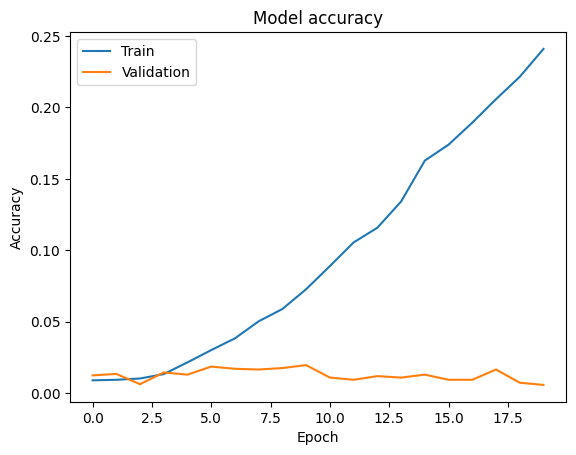

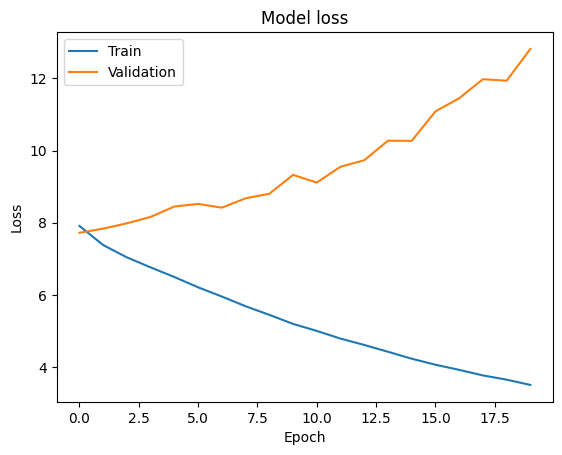

In [17]:
# Model training
epochs = 20
batch_size = 32

history = model.fit(
    [train_user_array, train_song_array, train_metadata_array],
    train_label_array,
    validation_data=(
        [val_user_array, val_song_array, val_metadata_array],
        val_label_array
    ),
    epochs=epochs,
    batch_size=batch_size
)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()